# Node embeddings and the MSRC-21 dataset

In [1]:
import tensorflow as tf
import plot_functions
import data_processing
import os
import numpy as np
import networkit
from auxiliarymethods import datasets as dp
from auxiliarymethods.reader import tud_to_networkx
import pandas as pd
from sklearn.decomposition import KernelPCA, TruncatedSVD
from matplotlib import pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score
import seaborn as sns
import sklearn
from scipy.sparse import load_npz
import auxiliarymethods.auxiliary_methods as aux
import networkx as nx
from sklearn.cluster import KMeans
from copy import deepcopy
import IPython
import re
import ipympl
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
%load_ext autoreload
%autoreload 2

2022-12-28 17:24:59.567121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from node2vec import Node2Vec
import tensorflow as tf

In [3]:
# utility functions
def load_csv(path):
    return np.loadtxt(path, delimiter=";")

def load_sparse(path):
    return load_npz(path)

def select_from_list(l, indices):
    return [l[i] for i in indices]

def cluster_average_nodes(G,classes):
    nodes_per_class = dict.fromkeys(np.unique(classes),0)
    graphs_per_class = dict.fromkeys(np.unique(classes),0)
    edges_per_class = dict.fromkeys(np.unique(classes),0)
    for graph in G:
        cluster = graph.graph["classes"][0]
        nodes_per_class[cluster] += len(graph.nodes)
        graphs_per_class[cluster] += 1
        edges_per_class[cluster] += len(graph.edges)

    average_nodes = {}
    average_edges = {}
    for cluster,no_graphs in graphs_per_class.items():
        average_nodes[cluster] = nodes_per_class[cluster] / no_graphs
        average_edges[cluster] = edges_per_class[cluster] / no_graphs
    return average_nodes,average_edges,graphs_per_class

In [373]:
# loading and preparing data

base_path = os.path.join("kernels", "node_labels")
ds_name = "MSRC_21"
classes = dp.get_dataset(ds_name)
G = tud_to_networkx(ds_name)
print(f"Number of graphs in data set is {len(G)}")
print(f"Number of classes {len(set(classes.tolist()))}")

Number of graphs in data set is 563
Number of classes 20


In [ ]:
file_classes = data_processing.create_img_index_by_class(classes)

# Recap


## The MSRC-21 dataset

The idea behind using graphs kernels on images is that an image can be described as consisting of connected superpixels. Superpixels summarise the information of a part of the picture and form nodes in the image graph, with adjacent superpixels being connected by nodes. The MSRC 21 dataset is a standard benchmark dataset for this kind of analysis first published by Winn et al. 2005 as part of Microsoft's research efforts. The image graph consists of image segments which carry a semantic label (see figure below). These semantic labels may both fall into a general "void" category and may have no label at all, representing noise. The MSRC-21 dataset contains the ground-truth of its image segmentation and is often used to test the accuracy of image segmentation algorithms; in our case, the main goal is the general classification of the images by theme given the known a semantically labelled graphs.

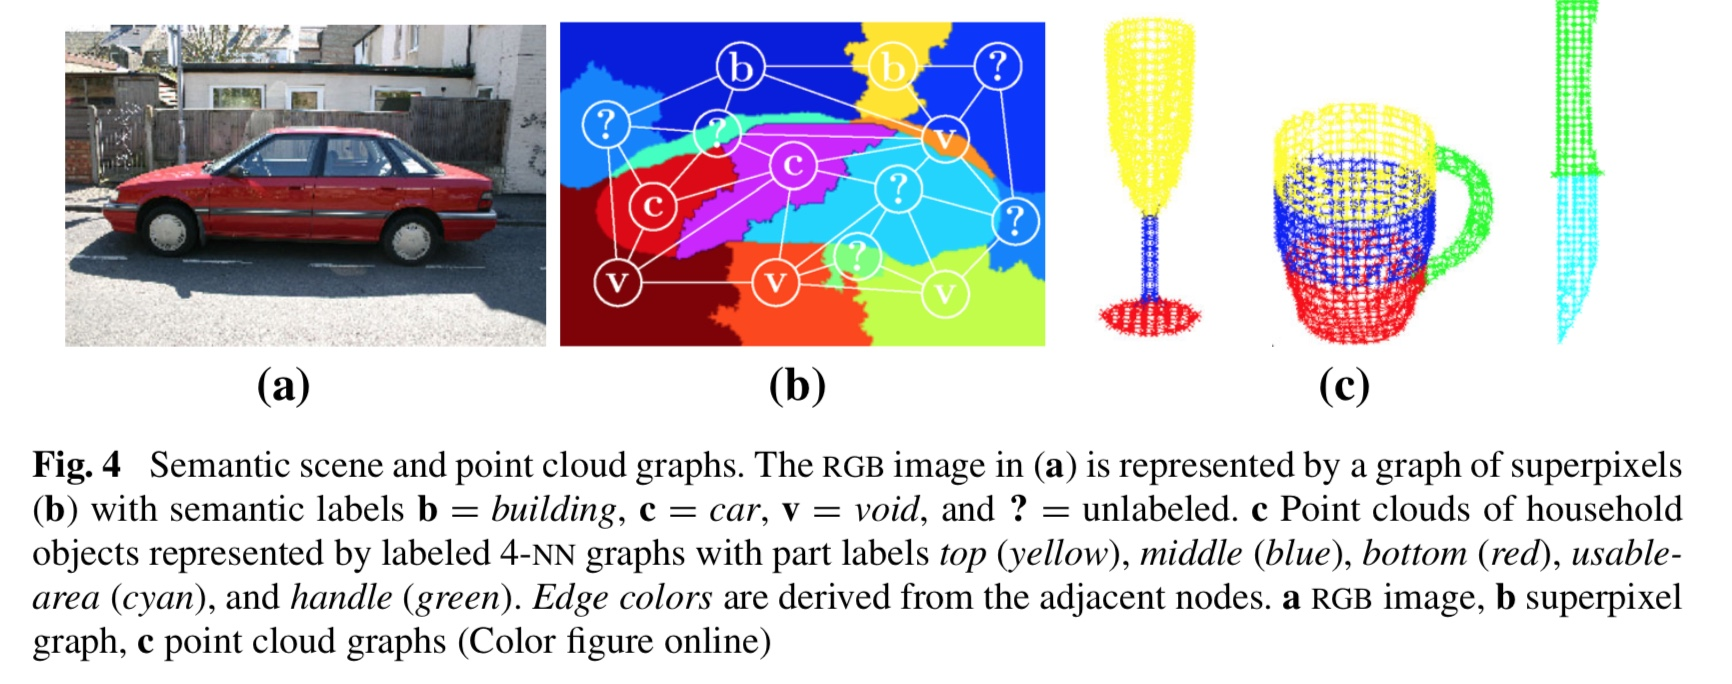

In [337]:
IPython.display.Image("assets/Neumann et al 2015 Fig 4.jpeg")

**References**

Kriege, N.M., Johansson, F.D., Morris, C.: A survey on graph kernels. Appl. Netw. Sci. 5(1), 6 (2020). https://doi.org/10.1007/s41109-019-0195-3

Neumann, M., Garnett, R., Bauckhage, C., Kersting, K.: Propagation kernels: efficient graph kernels from propagated information. Machine Learning pp. 1–37 (2015), http://dx.doi.org/10.1007/ s10994-015-5517-9

Winn, J. M., Criminisi, A., & Minka, T. P. (2005). Object categorization by learned universal visual dictionary. In 10th IEEE international conference on computer vision (ICCV-05), pp. 1800–1807.

https://www.microsoft.com/en-us/research/project/image-understanding/?from=http%3A%2F%2Fresearch.microsoft.com%2Fen-us%2Fprojects%2Fobjectclassrecognition%2F

# GNN baseline

The Tudataset contains baseline implementations of Graph Neural Networks for benchmark comparisons. We ran the GIN network with jumping knowledge to get an idea what kind of accuracy is achievable in our dataset.

In [335]:
import auxiliarymethods.datasets as dp
from auxiliarymethods.gnn_evaluation import gnn_evaluation
from gnn_baselines.gnn_architectures import GIN, GINE, GINEWithJK, GINWithJK


def gnn_mrsc21():
    num_reps = 1

    ### Smaller datasets.
    dataset = [["MSRC_21", True]]

    results = []
    for d, use_labels in dataset:
        # Download dataset.
        dp.get_dataset(d)

        # GIN, dataset d, layers in [1:6], hidden dimension in {32,64,128}.
        #acc, s_1, s_2 = gnn_evaluation(GIN, d, [1, 2, 3, 4, 5], [32, 64, 128], max_num_epochs=200, batch_size=64,
         #                              start_lr=0.01, num_repetitions=num_reps, all_std=True)
        #print(d + " " + "GIN " + str(acc) + " " + str(s_1) + " " + str(s_2))
        #results.append(d + " " + "GIN " + str(acc) + " " + str(s_1) + " " + str(s_2))

        # GIN with jumping knowledge, dataset d, layers in [1:6], hidden dimension in {32,64,128}.
        acc, s_1, s_2 = gnn_evaluation(GINWithJK, d, [1, 2, 3, 4, 5], [32, 64, 128], max_num_epochs=200,
                                       batch_size=64,
                                       start_lr=0.01, num_repetitions=num_reps, all_std=True)
        print(d + " " + "GINWithJK " + str(acc) + " " + str(s_1) + " " + str(s_2))
        results.append(d + " " + "GINWithJK " + str(acc) + " " + str(s_1) + " " + str(s_2))
    return results

In [336]:
gnn_mrsc21()
# takes forever to run

/opt/anaconda3/envs/dm_expl/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


MSRC_21 GINWithJK 89.86215538847118 0.0 3.31364789510349


['MSRC_21 GINWithJK 89.86215538847118 0.0 3.31364789510349']

# Embeddings

## node2vec

The node2vec embedding utilises 2nd order random walks of a given length to generate the network neighborhood of a node [1]. The bias in the walks is tuned by two hyperparameters p and q. The former serves as the probability to return to the previous node, while the latter gives the probability of moving further away from it. The number of walks, walk length and number of embedding dimensions can be specified. While the number of walks and their length increase the richness of the node embedding, they also severely affect performance [1]. Due to the generally high run-time, it was not possible to tune the hyperparameters to optimise them against our dataset. We simply used the default parameters suggested by the authors. 

The algorithm will return an embedding vector of a given dimensionality for each node. To relate these back to the overall graph, we used the approach of computing the sum, average and/or standard deviation of these embeddings for each graph.

The Python implementation of the original authors was used [2], with minor changes to make it comptabile to the newest version of Gensim.

[1] Grover, A., Leskovec, J.: Node2vec: Scalable feature learning for networks. In: Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Min- ing. p. 855–864. KDD ’16, Association for Computing Machinery, New York, NY, USA (2016). https://doi.org/10.1145/2939672.2939754, https://doi.org/10.1145/2939672.2939754

[2] https://snap.stanford.edu/node2vec/

In [338]:
?node2vec

In [342]:
def generate_node2vec(G, embedding_dims = 64, walk_length = 30, num_walks = 200, p = 1, q = 1):
    G_node2vec = []
    embedding_dims = 64
    walk_length = 30
    num_walks = 200

    for i,graph in enumerate(G):

        wv_filename = os.path.join("word_vectors","vectors{}_wl{}_dims{}.kv".format(i,walk_length,embedding_dims))
        if not os.path.exists(wv_filename):
            node2vec = Node2Vec(graph, dimensions=embedding_dims, walk_length=walk_length, num_walks=num_walks, workers=4)  # Use temp_folder for big graphs

        # Embed nodes
            model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)
            model.wv.save(wv_filename)
            G_node2vec.append(model.wv.get_normed_vectors())
        else:
            loaded_wv = KeyedVectors.load(wv_filename,mmap='r')
            G_node2vec.append(loaded_wv.get_normed_vectors())
    return G_node2vec

In [343]:
#generate_node2vec
embedding_dims = 64
G_node2vec = generate_node2vec(G,128,60,300)

Computing transition probabilities: 100%|█████| 59/59 [00:00<00:00, 3190.61it/s]

Computing transition probabilities: 100%|█████| 73/73 [00:00<00:00, 7966.91it/s]

Computing transition probabilities: 100%|█████| 68/68 [00:00<00:00, 7667.21it/s]

Computing transition probabilities: 100%|█████| 76/76 [00:00<00:00, 7651.27it/s]

Computing transition probabilities: 100%|█████| 69/69 [00:00<00:00, 7043.76it/s]

Computing transition probabilities: 100%|█████| 73/73 [00:00<00:00, 6577.67it/s]

Computing transition probabilities: 100%|█████| 64/64 [00:00<00:00, 8441.10it/s]

Computing transition probabilities: 100%|█████| 70/70 [00:00<00:00, 7181.15it/s]

Computing transition probabilities: 100%|█████| 76/76 [00:00<00:00, 7306.98it/s]

Computing transition probabilities: 100%|█████| 77/77 [00:00<00:00, 8034.87it/s]

Computing transition probabilities: 100%|█████| 83/83 [00:00<00:00, 7285.89it/s]

Computing transition probabilities: 100%|█████| 79/79 [00:00<00:00, 7810.99it/s]

Computing transi

KeyboardInterrupt: 

In [10]:
node2vec_embeddings = {}

node2vec_sums = np.zeros((len(G),embedding_dims))
for i,embedding in enumerate(G_node2vec):
    node2vec_sums[i] = embedding.sum(axis=0)
node2vec_embeddings["sum"] = node2vec_sums 

node2vec_means = np.zeros((len(G),embedding_dims))
for i,embedding in enumerate(G_node2vec):
    node2vec_means[i] = embedding.mean(axis=0)
node2vec_embeddings["mean"] = node2vec_means

node2vec_sd = np.zeros((len(G),embedding_dims))
for i,embedding in enumerate(G_node2vec):
    node2vec_sd[i] = embedding.std(axis=0)
node2vec_embeddings["sd"] = node2vec_sd
node2vec_embeddings["sum_mean_sd"] = np.hstack([node2vec_sums, node2vec_means,node2vec_sd])

## SpectralMix

Objective function: 

$min_{O,M} \sum_{r=1}^{|R|} \alpha_{r} \cdot \left( \sum_{e=(v_{i},v_{j},w_{ij},r) \in E_{r}} w_{ij} \cdot \sum_{l=1}^{d} ||o_{il}-i_{jl}||^{2} \right) + \sum_{i=1}^{n} \sum_{j=1}^{|A|} \alpha_{j} \cdot \sum_{l=1}^{d}||o_{il}-m_{il}||^2$

O = n x d matrix of coordinates with each row coordinate vector for node
First part of equation: relational part of data, $|R|$dimensional graph with position of ata object (all edges between $v_{i}$ and $v_{j}$, coordinate matrix O minimises squared euclidean distances
$o_{il}$ = coordinate of node $v_{i}$ in dimension l
This happens over multiple relations
d = dimension of embedding

Second summand: categorial information as a bipartite graph between nodes and categories, one for each categorical variable
c categorical graphs 
as in homogenity analysis, discover for every category $k_{j}$ of every attribute $A_{j}$ its position in $\mathbb{R}^{d}$
M (C x d matrix) contains coordinates of object $v_{i}$ in dimension l at position $m_{il}$

$\alpha_{r}, \alpha_{j}$ = weighting factors for relation types and categorical attributes (suggested to be equal)

constraint: orthonomality of O columns to ensure non-trivial solutions

initialised with O random values, then update O and M to minimise, converge if no longer increases

[1] Sadikaj, Y., Velaj, Y., Behzadi, S., Plant, C.: Spectral Clustering of Attributed Multi-Relational Graphs, p. 1431–1440. Association for Computing Machinery, New York, NY, USA (2021), https://doi.org/ 10.1145/3447548.3467381

[2] https://gitlab.cs.univie.ac.at/yllis19cs/spectralmixpublic


## Clustering and classification algorithms

The main task of this analysis is to study the effect of embeddings and graph properties on the algorithms, so we chose two very simple algorithms: Kmeans for clustering with a given cluster number of 20, and a SVM with a RBF kernel. The SVM uses a 80/20 training/test split and scaled data.

We also experimented with using very simple neural networks for the classification task, but found that we could not achieve good results - possibly due to the small sample size of only ca. 580 images we have at our disposal.

In [222]:
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
from sklearn import svm

def kmeans_batch(data,labels,runs):
    nmis = []
    for i in range(0,runs):
        kmeans = KMeans(n_clusters=20).fit(data)
        nmis.append(normalized_mutual_info_score(labels,kmeans.labels_))
    return np.mean(nmis)

def simple_nn(X,Y,train_split = 0.7):
    # shuffle data and split into train / test
    shuffled = np.arange(len(X))
    np.random.shuffle(shuffled)

    X = X[shuffled]
    Y = Y[shuffled]

    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    n_train = int(train_split*len(X))
    X_train= X[:n_train]
    X_test = X[n_train:]
    Y_train = Y[:n_train]
    Y_test = Y[n_train:]

    model = tf.keras.Sequential([
        #tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(64, activation='relu',input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(len(np.unique(classes)), activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_train, to_categorical(Y_train-1), epochs=10)
    test_loss, test_acc = model.evaluate(X_test,  to_categorical(Y_test-1), verbose=2)
    
    print('\nTest accuracy:', test_acc)
    
    return test_acc

def svm(X,Y,train_split = 0.8, runs = 10, kernel="rbf"):
    accuracies = []
    for i in range(0,runs):
    
        shuffled = np.arange(len(X))
        np.random.shuffle(shuffled)

        X = X[shuffled]
        Y = Y[shuffled]

        scaler = sklearn.preprocessing.StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
        n_train = int(train_split*len(X))
        X_train= X[:n_train]
        X_test = X[n_train:]
        Y_train = Y[:n_train]
        Y_test = Y[n_train:]

        svm = sklearn.svm.SVC(kernel=kernel)
        svm.fit(X_train,Y_train)

        acc = svm.score(X_test,Y_test)
        accuracies.append(acc)
    return np.mean(accuracies)

## Benchmarks for embeddings

In [339]:
for embedding_name, embedding in node2vec_embeddings.items():
    nmi = svm(embedding,classes,kernel = "rbf",runs=20)
    print("embedding: {} svm nmi: {}".format(embedding_name,nmi))
for embedding_name, embedding in node2vec_embeddings.items():
    best_nmi = kmeans_batch(embedding,classes,runs=20)
    print("embedding: {} average kmeans nmi: {}".format(embedding_name,best_nmi))

embedding: sum svm nmi: 0.046449704142011834
embedding: mean svm nmi: 0.04940828402366864
embedding: sd svm nmi: 0.04053254437869823
embedding: sum_mean_sd svm nmi: 0.03757396449704142
embedding: sum average kmeans nmi: 0.12389179112438269
embedding: mean average kmeans nmi: 0.12902655447258338
embedding: sd average kmeans nmi: 0.12719835201510188
embedding: sum_mean_sd average kmeans nmi: 0.12452173581813406


# Enhancing the embedding

# Node-level attributes

Give those to SpectralMix, can deal with attributes

### Degree
measures number of connected nodes

In [374]:
for graph in G:
    degrees = graph.degree()
    for node_degree in degrees:
        graph.nodes[node_degree[0]]["degree"] = node_degree[1]

In [ ]:
G[0].nodes[0]

### Eigenvector centrality
Nodes are important if their neighbours are important. 
Eigenvector centrality of a node v $c_{v} = \frac{1}{\lambda}\sum_{u \in N(v)}c_{u}$

High values for nodes that are tightly clustered together. Usefulness for image data: probably not

In [391]:
for graph in G:
    eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter = 1000)
    nx.set_node_attributes(graph, eigenvector_centrality, "eigenvector_centrality")

### Betweenness centrality

Nodes are important if they lie on many shortest path within graph. 

$c_{v} = \sum_{s \neq v \neq t}\frac{\text{# shortest path between s and t that contains v}}{\text{# shortest path between s and t}}$

The shortest paths can be weighted by edge attributes greater than zero, such that the weight is interpreted as distance between node. Further, the results can be normalized.

High values indicate that a node serves an important connecting function in the overall graph. Usefulness for our image data: probably not

In [390]:
for graph in G:
    betweenness_centrality = nx.betweenness_centrality(graph, normalized=True)
    nx.set_node_attributes(graph, betweenness_centrality, "betweenness_centrality")

### Closeness centrality

Importance is measured if length of shortest path to all other nodes is small

$c_{v} = \frac{1}{\sum_{u \neq v}\text{shortest path length between u and v}}$

In Networkx, this measure goes under harmonic centrality, while closeness centrality is implemented as 

$C(u)=\frac{n-1}{\sum_{v=1}^{n-1}d(v,u)}$ 

where n-1 nodes are reachable from v and d(v,u) is the shortest path distance between v and u. If the graphs consist only of connected components, as in our case, the measure should be identical.

In [389]:
for graph in G:
    closeness_centrality = nx.closeness_centrality(graph)
    nx.set_node_attributes(graph, closeness_centrality, "closeness_centrality")

In [388]:
for graph in G:
    harmonic_centrality = nx.harmonic_centrality(graph)
    nx.set_node_attributes(graph, harmonic_centrality, "harmonic_centrality")

### Clustering coefficient

Nodes are important if their neighbouring nodes are connected with each other.

$e_{v} = \frac{\text{#edges among neighbouring nodes}}{(\frac{k_{v}}{2})} \in [0,1]$

In [387]:
for graph in G:
    clustering_coefficient = nx.clustering(graph)
    nx.set_node_attributes(graph, clustering_coefficient, "clustering_coefficient")

### Pagerank

Recursive definition:

$PR_{i}=\frac{1-d}{n}+d\sum_{j=1}^{n}\frac{PR_{j}}{c_{j}}$

PageRank of node i is the Pagerank of all nodes j linking to it, divided by the number of nodes c that j links to.
It is weighted by a dampening factor d (0-1) that prevents nodes without outgoing links to suck up all the weight, a part of the total sum is distributed among all nodes n.

In [386]:
for graph in G:
    pagerank = nx.pagerank(graph)
    nx.set_node_attributes(graph, pagerank, "pagerank")

In [ ]:
# degree sequence by node label?

# Graph-attributes

### Number of nodes and edges

In [385]:
for graph in G:
    no_nodes = len(graph.nodes)
    no_edges = len(graph.edges)
    graph.graph["nodes"] = no_nodes
    graph.graph["edges"] = no_edges

### Degree histogram or distribution 

In [380]:
degree_sequences = []
dmax_total = 0
for graph in G:
    # after networkx doc
    degree_sequence = sorted((d for n, d in graph.degree()), reverse=True)
    dmax = max(degree_sequence)
    if dmax > dmax_total:
        dmax_total = dmax
    unique, counts = np.unique(degree_sequence, return_counts=True)
    
    degree_sequence = np.zeros((dmax+1))
    for label,count in zip(unique,counts):
        degree_sequence[label] = count
    degree_sequences.append(degree_sequence)
    
for graph,sequence in zip(G,degree_sequences):
    degree_hist = np.zeros((dmax_total+1))
    degree_hist[:len(sequence)] = sequence
    graph.graph["degree_hist"] = degree_hist

### Node label histogram

In [378]:
nl_sequences = []
nlmax_total = 0
for graph in G:

    nl_max = 0
    for node in graph.nodes.items():
        label = node[1]["labels"][0]
        if label > nl_max:
            nl_max = label
    nl_sequence = np.zeros((nl_max+1))
    
    for node in graph.nodes.items():
        label = node[1]["labels"][0]
        nl_sequence[label] += 1
    
    if nl_max > nlmax_total:
        nlmax_total = nl_max
    nl_sequences.append(nl_sequence)

for graph,sequence in zip(G,nl_sequences):
    nl_hist = np.zeros((nlmax_total+1))
    nl_hist[:len(sequence)] = sequence
    graph.graph["node_label_hist"] = nl_hist

### Connectivity

In [383]:
# no of nodes you need to remove to disconnect graph

for graph in G:
    connectivity = nx.node_connectivity(graph)
    graph.graph["connectivity"] = connectivity

### Max clique labels

Cliques are the subgraphs of any given graph that are complete. Corresponding to our image data, these might be considered as areas of densely packed information. By including the node labels for these, we hope to emphasize areas of high information in the picture.


In [381]:
for graph in G:
    clique_lists = list(nx.find_cliques(graph))
    clique_label_hist = np.zeros_like(graph.graph["node_label_hist"])
    for clique_list in clique_lists:
        for node in clique_list:
            label = graph.nodes[node]["labels"][0]
            clique_label_hist[label] += 1
    graph.graph["clique_label_hist"] = clique_label_hist

### Treewidth

How close graph is to a tree

In [382]:
for graph in G:
    tree_width = nx.approximation.treewidth_min_degree(graph)
    graph.graph["tree_width"] = tree_width

## node2vec enhanced



In [137]:
node2vec_embeddings.keys()

dict_keys(['sum', 'mean', 'sd', 'sum_mean_sd'])

In [146]:
# add best performing base embedding
# add graph level attributes
# see what performs best

In [392]:
node_label_hist = np.zeros((len(G),25))
degree_hist = np.zeros((len(G),24))
tree_widths = np.zeros((len(G),1))
connectivities = np.zeros((len(G),1))
clique_hist = np.zeros((len(G),25))
no_nodes = np.zeros((len(G),1))
no_edges = np.zeros((len(G),1))
pagerank_hist = np.zeros((len(G),20))

for i,graph in enumerate(G):
    node_label_hist[i,:] = graph.graph["node_label_hist"]
    degree_hist[i,:] = graph.graph["degree_hist"]
    tree_widths[i,:] = graph.graph["tree_width"][0]
    connectivities[i,:] = graph.graph["connectivity"]
    clique_hist[i,:] = graph.graph["clique_label_hist"]
    no_nodes[i,:] = graph.graph["nodes"]
    no_edges[i,:] = graph.graph["edges"]
    pagerank_hist[i,:] = np.histogram(list(nx.get_node_attributes(graph,"pagerank").values()),20)[0]

## Benchmarks of enhanced embeddings

In [393]:
node2vec_enhanced = {}

#All graph properties without node label information
node2vec_enhanced["sum_all_without_node_labels"] = np.hstack([node2vec_embeddings["sum"],pagerank_hist,no_nodes,no_edges,tree_widths,connectivities,degree_hist])

#Combination of properties
node2vec_enhanced["sum_label_hist"] = np.hstack([node2vec_embeddings["sum"],node_label_hist])
node2vec_enhanced["sum_label_degree_hist"] = np.hstack([node2vec_embeddings["sum"],node_label_hist,degree_hist])
node2vec_enhanced["sum_label_hist_tree_width"] = np.hstack([node2vec_embeddings["sum"],node_label_hist,tree_widths])
node2vec_enhanced["sum_all"] = np.hstack([node2vec_embeddings["sum"],no_nodes,no_edges,clique_hist,node_label_hist,tree_widths,connectivities,degree_hist,pagerank_hist])

# Node label information only
node2vec_enhanced["sum_clique_label"] = np.hstack([node2vec_embeddings["sum"],clique_hist])
node2vec_enhanced["mean_labels"] = np.hstack([node2vec_embeddings["mean"],clique_hist,node_label_hist])
node2vec_enhanced["sum_labels"] = np.hstack([node2vec_embeddings["sum"],clique_hist,node_label_hist])
node2vec_enhanced["sum_mean_sd_labels"] = np.hstack([node2vec_embeddings["sum_mean_sd"],clique_hist,node_label_hist])


In [394]:
for embedding_name, embedding in node2vec_enhanced.items():
    best_nmi = kmeans_batch(embedding,classes,20)
    print("embedding: {} average kmeans nmi: {}".format(embedding_name,best_nmi))

embedding: sum_all_without_node_labels average kmeans nmi: 0.15208543136669572
embedding: sum_label_hist average kmeans nmi: 0.6105535177002911
embedding: sum_label_degree_hist average kmeans nmi: 0.6103108095700684
embedding: sum_label_hist_tree_width average kmeans nmi: 0.6103646627937533
embedding: sum_all average kmeans nmi: 0.6396852788992934
embedding: sum_clique_label average kmeans nmi: 0.6484299984860173
embedding: mean_labels average kmeans nmi: 0.6443067219127483
embedding: sum_labels average kmeans nmi: 0.646230621363126
embedding: sum_mean_sd_labels average kmeans nmi: 0.6454012603187639


In [395]:
# have to repeat and average, varies wildly
for embedding_name, embedding in node2vec_enhanced.items():
    nmi = svm(embedding,classes,runs = 20, kernel = "rbf")
    print("embedding: {} average svm nmi: {}".format(embedding_name,nmi))

embedding: sum_all_without_node_labels average svm nmi: 0.07603550295857989
embedding: sum_label_hist average svm nmi: 0.7307692307692307
embedding: sum_label_degree_hist average svm nmi: 0.7215976331360946
embedding: sum_label_hist_tree_width average svm nmi: 0.7310650887573964
embedding: sum_all average svm nmi: 0.7692307692307693
embedding: sum_clique_label average svm nmi: 0.7340236686390532
embedding: mean_labels average svm nmi: 0.8047337278106509
embedding: sum_labels average svm nmi: 0.7890532544378698
embedding: sum_mean_sd_labels average svm nmi: 0.6899408284023669


# Discussion of results

### node2vec
Adding any graph structural properties only marginally increases results for both classifiers. The by far biggest impact can be achieved by adding the node label histogram and the clique nodel label histogram. Both combined with the mean aggregation of node2vec can achieve average accuracies over 0.8 for the SVM. They lose accuracy if they are diluted with any number of graph properties that are not related to node label information.

Overall, it seems that node2vec already covers most information that can be gained from graph properties. It only lacks the ability to directly incorporate label information, which can be amended by simple concatenation.



### SpectralMix

resources used
GNN: 
https://towardsdatascience.com/understanding-graph-convolutional-networks-for-node-classification-a2bfdb7aba7b
https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-7d2250723780
https://distill.pub/2021/gnn-intro/#graph-to-tensor
https://antonsruberts.github.io/graph/gcn/

In [ ]:
# plot some graphs with labels as info

In [344]:
G[0].graph

{'classes': [5],
 'node_label_hist': array([ 0.,  1.,  0., 69.,  0., 11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'degree_hist': array([ 0.,  0.,  3.,  8., 23., 18.,  4., 13.,  7.,  0.,  4.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'tree_width': (9, <networkx.classes.graph.Graph at 0x18544cd60>),
 'connectivity': 2,
 'nodes': 81,
 'edges': 217,
 'clique_label_hist': array([  0.,   2.,   0., 289.,   0.,  59.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.])}

In [396]:
from networkx.readwrite import json_graph
from copy import deepcopy
import json

for i,graph in enumerate(G):
    data = deepcopy(nx.node_link_data(graph))
    data["graph"]["clique_label_hist"] = data["graph"]["clique_label_hist"].tolist()
    data["graph"]["degree_hist"] = data["graph"]["degree_hist"].tolist()
    data["graph"]["node_label_hist"] = data["graph"]["node_label_hist"].tolist()
    data["graph"]["tree_width"] = None
    s = json.dumps(data)
    filename = "msrc21_{}.json".format(i)
    with open(filename, "w") as file:
        file.write(s)